# Solar Panel Segmentation with U-Net (EfficientNet Backbone)

## 0. Environment Setup

In [ ]:
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00:00:0100:01


In [ ]:
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download('salimhammadi07/solar-panel-detection-and-identification')
dataset_path = Path(dataset_path)

## 1. Dataset Structure and Visualization

### 1.1 Create DataFrame for Image-Mask Pairs

In [ ]:
base_path = Path(dataset_path/"PV03")

In [ ]:
records = []

In [ ]:
for subfolder in base_path.glob("PV03_*"):
    for img_file in subfolder.glob("*.bmp"):
        if "_label" in img_file.stem.lower():
            continue

        mask_name = img_file.stem + "_label.bmp"
        mask_path = subfolder / mask_name

        if not mask_path.exists():
            continue

        # Add record
        records.append({
            "image_path": str(img_file.resolve()),
            "mask_path": str(mask_path.resolve()),
            "image_name": img_file.stem,
            "source_type": subfolder.name
        })

df = pd.DataFrame(records)
df.head()

,image_path,mask_path,image_name,source_type
0,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_334077_1181454,PV03_Ground_Shrubwood
1,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_332037_1180245,PV03_Ground_Shrubwood
2,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_331848_1180579,PV03_Ground_Shrubwood
3,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_334183_1181155,PV03_Ground_Shrubwood
4,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_332120_1180277,PV03_Ground_Shrubwood


### 1.2 Source Type Distribution

In [ ]:
df["source_type"].value_counts()

source_type
PV03_Ground_Cropland        859
PV03_Ground_WaterSurface    625
PV03_Ground_SalineAlkali    352
PV03_Rooftop                236
PV03_Ground_Shrubwood       119
PV03_Ground_Grassland       117
Name: count, dtype: int64

### 1.3 Random Sample Visualization

In [ ]:
sample_df = df.sample(5, random_state=42)
sample_df

,image_path,mask_path,image_name,source_type
1642,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_348926_1168427,PV03_Ground_Cropland
509,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_325164_1211162,PV03_Ground_SalineAlkali
1134,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_332191_1197377,PV03_Ground_Cropland
44,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_338160_1178779,PV03_Ground_Shrubwood
973,/kaggle/input/solar-panel-detection-and-identi...,/kaggle/input/solar-panel-detection-and-identi...,PV03_342273_1191444,PV03_Ground_Cropland


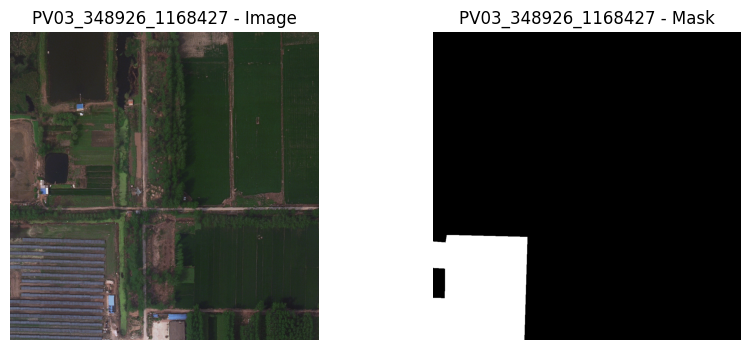

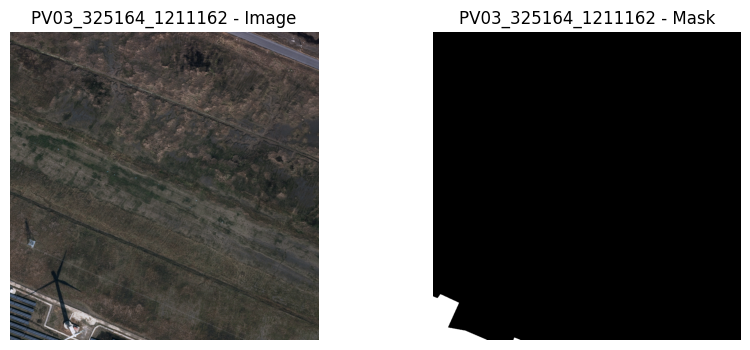

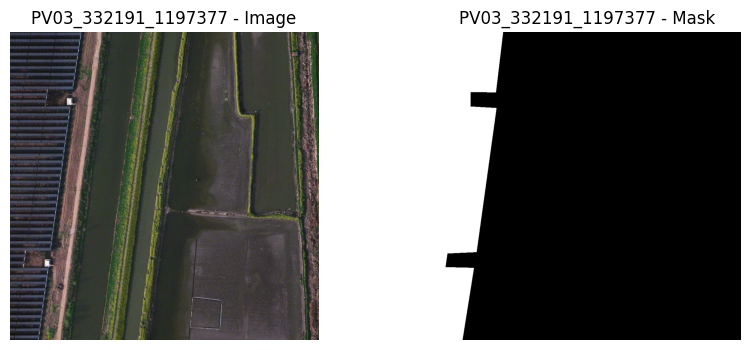

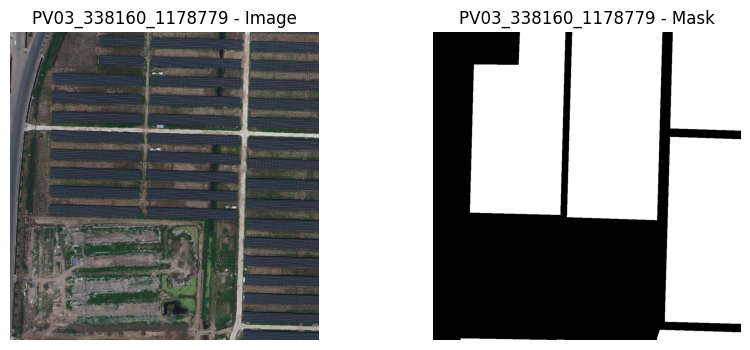

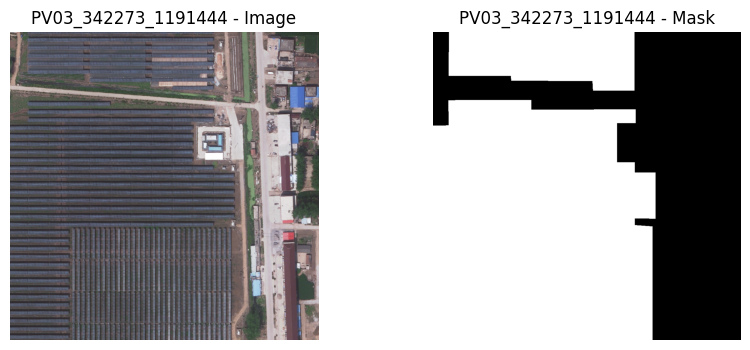

In [ ]:
for idx, row in sample_df.iterrows():
    image_path = row["image_path"]
    mask_path = row["mask_path"]
    image_name = row["image_name"]

    image = Image.open(image_path)
    mask = Image.open(mask_path)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(f"{image_name} - Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"{image_name} - Mask")
    plt.axis("off")

## 2. Train/Test/Val Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["source_type"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df["source_type"], random_state=42)

print(f"Train: {len(train_df)}, Test: {len(test_df)}, Val: {len(val_df)}")

Train: 1661, Test: 462, Val: 185


## 3. Data Preprocessing

### 3.1 Custom Dataset Class: `SolarPanaelDataset`

In [ ]:
class SolarPanelDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        image = np.array(Image.open(img_path).convert('RGB'))
        mask_path = row['mask_path']
        mask = np.array(Image.open(mask_path).convert('L'))

        mask = (mask > 0).astype('float32')

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image'].float()
            mask = transformed['mask']

        return image, mask.unsqueeze(0).float()


### 3.2  Image and Mask Transformations

In [ ]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

### 3.3 Initialize Train/Test/Val Datasets

In [ ]:
train_dataset = SolarPanelDataset(train_df, transforms = train_transform)
test_dataset = SolarPanelDataset(test_df, transforms = test_transform)
val_dataset = SolarPanelDataset(val_df, transforms = val_transform)

### 3.4 DataLoader Creation

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)

## 4. Model Architecture

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = smp.Unet(
    encoder_name = "efficientnet-b0",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 1
).to(device)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## 5. Define Loss/Optimizer/Metrics

### 5.1 Dice and BCE Loss

In [ ]:
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

### 5.2 Combined Loss

In [ ]:
def combined_loss(preds, targets):
    return dice_loss(preds, targets) + bce_loss(preds, targets)

### 5.3 Optimizer Setup

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### 5.4 Define Metrics

In [ ]:
def compute_metrics(preds, targets, threshold=0.5):
    # Apply sigmoid + threshold
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds_np = preds.detach().cpu().numpy().astype(int).flatten()
    targets_np = targets.detach().cpu().numpy().astype(int).flatten()

    f1 = f1_score(targets_np, preds_np, zero_division=0)
    precision = precision_score(targets_np, preds_np, zero_division=0)
    recall = recall_score(targets_np, preds_np, zero_division=0)
    accuracy = accuracy_score(targets_np, preds_np)

    return f1, precision, recall, accuracy


## 6. Training and Validation Loops (with Early Stopping)

In [ ]:
best_val_f1 = 0
patience = 10
patience_counter = 0
best_model_path = "best_model.pth"

train_losses = []
val_losses = []
val_f1s = []

epochs = 40
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    model.train()
    train_loss = 0
    train_f1, train_precision, train_recall, train_accuracy = [], [], [], []

    for batch, (images, masks) in enumerate(tqdm(train_loader)):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = combined_loss(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        f1, prec, rec, acc = compute_metrics(outputs, masks)
        train_f1.append(f1)
        train_precision.append(prec)
        train_recall.append(rec)
        train_accuracy.append(acc)

        if ((batch+1) % 30) == 0:
            print(f"[Batch {batch+1}/{len(train_loader)}] Processed")

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_f1 = sum(train_f1) / len(train_f1)
    epoch_train_precision = sum(train_precision) / len(train_precision)
    epoch_train_recall = sum(train_recall) / len(train_recall)
    epoch_train_accuracy = sum(train_accuracy) / len(train_accuracy)

    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0
    val_f1, val_precision, val_recall, val_accuracy = [], [] ,[], []
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = combined_loss(outputs, masks)

            val_loss += loss.item()

            f1, prec, rec, acc = compute_metrics(outputs, masks)
            val_f1.append(f1)
            val_precision.append(prec)
            val_recall.append(rec)
            val_accuracy.append(acc)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_f1 = sum(val_f1) / len(val_f1)
    epoch_val_precision = sum(val_precision) / len(val_precision)
    epoch_val_recall = sum(val_recall) / len(val_recall)
    epoch_val_accuracy = sum(val_accuracy) / len(val_accuracy)

    val_losses.append(epoch_val_loss)
    val_f1s.append(epoch_val_f1)

    print(f"[Train] Loss: {epoch_train_loss:.4f} | F1: {epoch_train_f1:.4f} | Accuracy: {epoch_train_accuracy:.3f}% | Precision: {epoch_train_precision:.4f} | Recall: {epoch_train_recall:.4f}")
    print(f"[Val] Loss: {epoch_val_loss:.4f} | F1: {epoch_val_f1:.4f} | Accuracy: {epoch_val_accuracy:.3f}% | Precision: {epoch_val_precision:.4f} | Recall: {epoch_val_recall:.4f}")

     # Save best model and early stopping
    if epoch_val_f1 > best_val_f1:
        best_val_f1 = epoch_val_f1
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model (F1: {best_val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.6737 | F1: 0.8268 | Accuracy: 0.908% | Precision: 0.8153 | Recall: 0.8560
[Val] Loss: 0.3652 | F1: 0.9285 | Accuracy: 0.960% | Precision: 0.8928 | Recall: 0.9707
Saved new best model (F1: 0.9285)

Epoch 2/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.3552 | F1: 0.9091 | Accuracy: 0.953% | Precision: 0.8878 | Recall: 0.9480
[Val] Loss: 0.2398 | F1: 0.9395 | Accuracy: 0.967% | Precision: 0.9122 | Recall: 0.9717
Saved new best model (F1: 0.9395)

Epoch 3/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.2671 | F1: 0.9259 | Accuracy: 0.961% | Precision: 0.9083 | Recall: 0.9527
[Val] Loss: 0.1860 | F1: 0.9480 | Accuracy: 0.972% | Precision: 0.9386 | Recall: 0.9604
Saved new best model (F1: 0.9480)

Epoch 4/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.2412 | F1: 0.9268 | Accuracy: 0.963% | Precision: 0.9069 | Recall: 0.9579
[Val] Loss: 0.1735 | F1: 0.9466 | Accuracy: 0.971% | Precision: 0.9277 | Recall: 0.9694
No improvement. Patience: 1/10

Epoch 5/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.2154 | F1: 0.9318 | Accuracy: 0.966% | Precision: 0.9158 | Recall: 0.9580
[Val] Loss: 0.1687 | F1: 0.9463 | Accuracy: 0.971% | Precision: 0.9406 | Recall: 0.9549
No improvement. Patience: 2/10

Epoch 6/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1974 | F1: 0.9383 | Accuracy: 0.969% | Precision: 0.9227 | Recall: 0.9609
[Val] Loss: 0.1454 | F1: 0.9526 | Accuracy: 0.974% | Precision: 0.9410 | Recall: 0.9678
Saved new best model (F1: 0.9526)

Epoch 7/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1681 | F1: 0.9485 | Accuracy: 0.972% | Precision: 0.9369 | Recall: 0.9631
[Val] Loss: 0.1455 | F1: 0.9509 | Accuracy: 0.974% | Precision: 0.9434 | Recall: 0.9607
No improvement. Patience: 1/10

Epoch 8/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1641 | F1: 0.9475 | Accuracy: 0.974% | Precision: 0.9346 | Recall: 0.9644
[Val] Loss: 0.1461 | F1: 0.9513 | Accuracy: 0.974% | Precision: 0.9386 | Recall: 0.9660
No improvement. Patience: 2/10

Epoch 9/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1492 | F1: 0.9528 | Accuracy: 0.975% | Precision: 0.9444 | Recall: 0.9639
[Val] Loss: 0.1502 | F1: 0.9492 | Accuracy: 0.973% | Precision: 0.9452 | Recall: 0.9561
No improvement. Patience: 3/10

Epoch 10/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1426 | F1: 0.9529 | Accuracy: 0.976% | Precision: 0.9445 | Recall: 0.9646
[Val] Loss: 0.1396 | F1: 0.9543 | Accuracy: 0.975% | Precision: 0.9460 | Recall: 0.9662
Saved new best model (F1: 0.9543)

Epoch 11/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1394 | F1: 0.9545 | Accuracy: 0.976% | Precision: 0.9467 | Recall: 0.9643
[Val] Loss: 0.1303 | F1: 0.9560 | Accuracy: 0.976% | Precision: 0.9434 | Recall: 0.9712
Saved new best model (F1: 0.9560)

Epoch 12/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1299 | F1: 0.9568 | Accuracy: 0.977% | Precision: 0.9510 | Recall: 0.9645
[Val] Loss: 0.1239 | F1: 0.9566 | Accuracy: 0.977% | Precision: 0.9449 | Recall: 0.9711
Saved new best model (F1: 0.9566)

Epoch 13/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1348 | F1: 0.9556 | Accuracy: 0.976% | Precision: 0.9499 | Recall: 0.9632
[Val] Loss: 0.1222 | F1: 0.9579 | Accuracy: 0.977% | Precision: 0.9528 | Recall: 0.9650
Saved new best model (F1: 0.9579)

Epoch 14/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1261 | F1: 0.9580 | Accuracy: 0.978% | Precision: 0.9529 | Recall: 0.9647
[Val] Loss: 0.1249 | F1: 0.9566 | Accuracy: 0.976% | Precision: 0.9477 | Recall: 0.9678
No improvement. Patience: 1/10

Epoch 15/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1209 | F1: 0.9599 | Accuracy: 0.978% | Precision: 0.9565 | Recall: 0.9645
[Val] Loss: 0.1240 | F1: 0.9557 | Accuracy: 0.976% | Precision: 0.9405 | Recall: 0.9741
No improvement. Patience: 2/10

Epoch 16/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1258 | F1: 0.9564 | Accuracy: 0.977% | Precision: 0.9497 | Recall: 0.9652
[Val] Loss: 0.1427 | F1: 0.9504 | Accuracy: 0.972% | Precision: 0.9446 | Recall: 0.9601
No improvement. Patience: 3/10

Epoch 17/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1116 | F1: 0.9614 | Accuracy: 0.980% | Precision: 0.9576 | Recall: 0.9667
[Val] Loss: 0.1649 | F1: 0.9504 | Accuracy: 0.973% | Precision: 0.9542 | Recall: 0.9515
No improvement. Patience: 4/10

Epoch 18/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1140 | F1: 0.9612 | Accuracy: 0.979% | Precision: 0.9579 | Recall: 0.9656
[Val] Loss: 0.1307 | F1: 0.9527 | Accuracy: 0.974% | Precision: 0.9527 | Recall: 0.9560
No improvement. Patience: 5/10

Epoch 19/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1059 | F1: 0.9624 | Accuracy: 0.980% | Precision: 0.9598 | Recall: 0.9663
[Val] Loss: 0.1703 | F1: 0.9439 | Accuracy: 0.969% | Precision: 0.9596 | Recall: 0.9323
No improvement. Patience: 6/10

Epoch 20/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1083 | F1: 0.9620 | Accuracy: 0.980% | Precision: 0.9592 | Recall: 0.9659
[Val] Loss: 0.1527 | F1: 0.9508 | Accuracy: 0.973% | Precision: 0.9604 | Recall: 0.9452
No improvement. Patience: 7/10

Epoch 21/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1085 | F1: 0.9620 | Accuracy: 0.980% | Precision: 0.9601 | Recall: 0.9651
[Val] Loss: 0.1272 | F1: 0.9543 | Accuracy: 0.976% | Precision: 0.9522 | Recall: 0.9601
No improvement. Patience: 8/10

Epoch 22/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1044 | F1: 0.9631 | Accuracy: 0.980% | Precision: 0.9611 | Recall: 0.9660
[Val] Loss: 0.1431 | F1: 0.9528 | Accuracy: 0.974% | Precision: 0.9552 | Recall: 0.9544
No improvement. Patience: 9/10

Epoch 23/40


  0%|          | 0/208 [00:00<?, ?it/s]

[Batch 30/208] Processed
[Batch 60/208] Processed
[Batch 90/208] Processed
[Batch 120/208] Processed
[Batch 150/208] Processed
[Batch 180/208] Processed


  0%|          | 0/24 [00:00<?, ?it/s]

[Train] Loss: 0.1072 | F1: 0.9619 | Accuracy: 0.980% | Precision: 0.9608 | Recall: 0.9646
[Val] Loss: 0.1288 | F1: 0.9520 | Accuracy: 0.974% | Precision: 0.9517 | Recall: 0.9560
No improvement. Patience: 10/10
Early stopping triggered.


## 7. Evaluation on Test Set

### 7.1 Binary Classification Report

In [ ]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        outputs = (outputs > 0.5).float()

        # Flatten
        all_preds.extend(outputs.cpu().numpy().astype(int).flatten())
        all_targets.extend(masks.cpu().numpy().astype(int).flatten())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

  0%|          | 0/58 [00:00<?, ?it/s]

In [ ]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9852    0.9858    0.9855  22284202
           1     0.9604    0.9588    0.9596   7993430

    accuracy                         0.9787  30277632
   macro avg     0.9728    0.9723    0.9726  30277632
weighted avg     0.9787    0.9787    0.9787  30277632



### 7.2 Confusion Matrix

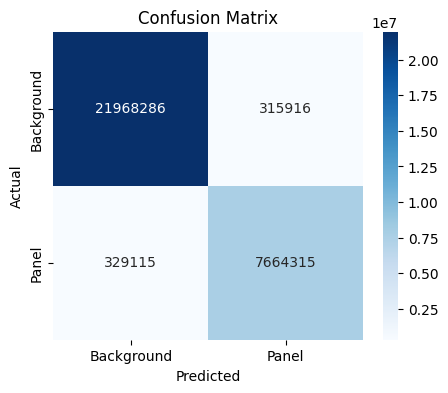

In [ ]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Panel'], yticklabels=['Background', 'Panel'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 8. Prediction Visualization

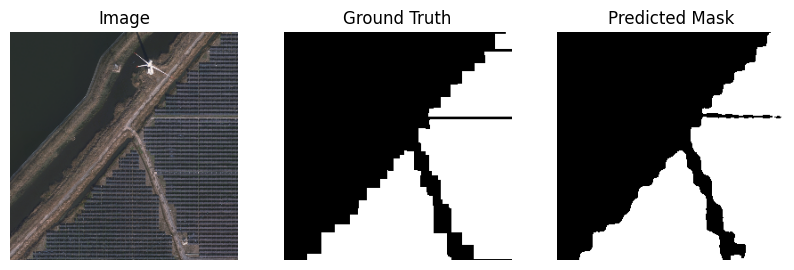

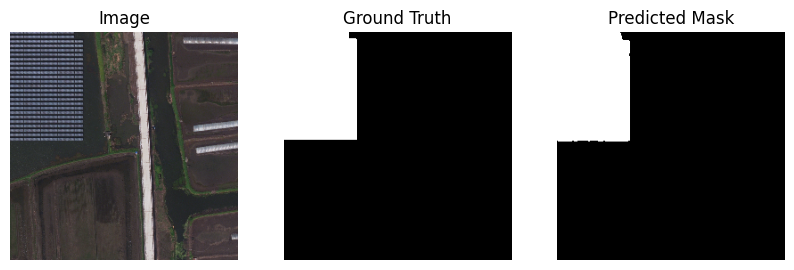

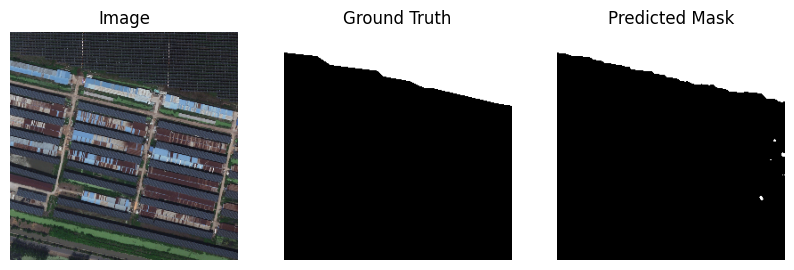

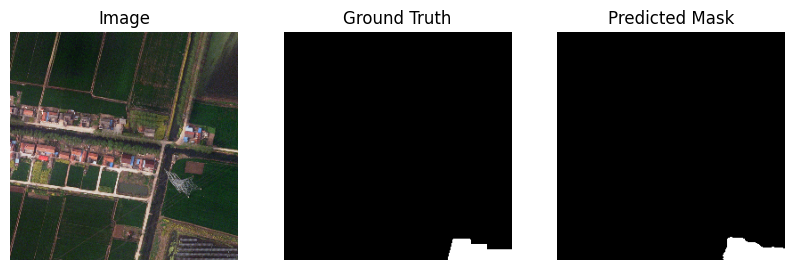

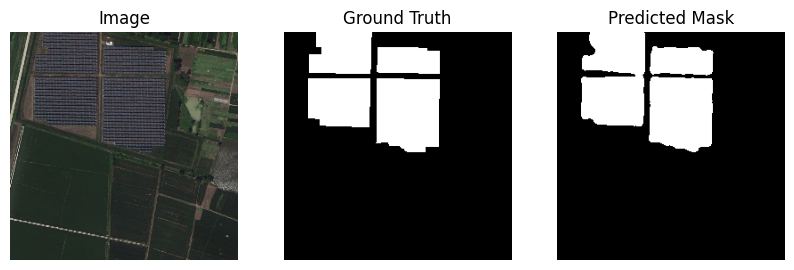

In [ ]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_predictions(model, dataset, n=5, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    model.eval()
    indices = np.random.choice(len(dataset), size=n, replace=False)

    for idx in indices:
        image, true_mask = dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        original_size = true_mask.shape[1:]  # shape = (1, H, W)

        with torch.no_grad():
            pred_mask = torch.sigmoid(model(image_input))  # Shape: [1, 1, 256, 256]
            pred_mask = F.interpolate(pred_mask, size=original_size, mode='bilinear', align_corners=False)
            pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy()

        true_mask_np = true_mask.squeeze().numpy()

        # Unnormalize image
        unnorm_image = unnormalize(image.clone(), mean, std).clamp(0, 1)
        image_np = TF.to_pil_image(unnorm_image)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()


visualize_predictions(model, test_dataset, n=5)

## 9. Training Curves

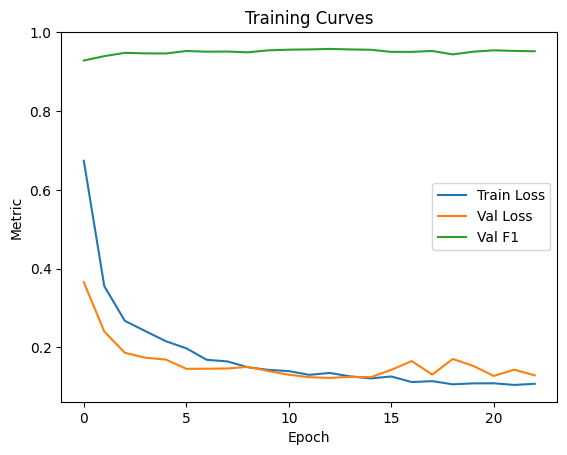

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Curves")
plt.legend()
plt.show()